In [15]:
!pip install -q --upgrade "httpx[http2]" tqdm pandas matplotlib datasets tiktoken transformers seaborn


In [9]:
VLLM = "https://llama3-vllm-vs-tgis.apps.cluster-jj67w.jj67w.sandbox1788.opentlc.com"
TGI  = "https://llama3-default.apps.cluster-jj67w.jj67w.sandbox1788.opentlc.com"
MODEL_ID = "meta-llama/Meta-Llama-3-8B-Instruct"

WARMUP_SECS = 20          # settle CUDA graphs / flash-cache
DUR_SECS    = 40          # measurement window
CONCURRENCY = [1, 4, 8, 16, 32]

HEADERS = {"Content-Type": "application/json"}


In [17]:
from datasets import load_dataset
import random, textwrap, os

LOCAL_PROMPT_FILE = "prompts.txt"

# Load from disk if file exists
if os.path.exists(LOCAL_PROMPT_FILE):
    with open(LOCAL_PROMPT_FILE, "r") as f:
        prompts = [line.strip() for line in f if line.strip()]
    print(f"✅ Loaded {len(prompts)} prompts from {LOCAL_PROMPT_FILE}")
else:
    # Download from Hugging Face and save locally
    dataset = load_dataset("wikipedia", "20220301.en", split="train[:1%]").shuffle(seed=42)
    prompts = dataset["text"][:1000]
    with open(LOCAL_PROMPT_FILE, "w") as f:
        for prompt in prompts:
            f.write(prompt.replace('\n', ' ') + "\n")
    print(f"📥 Downloaded and saved {len(prompts)} prompts to {LOCAL_PROMPT_FILE}")


✅ Loaded 1000 prompts from prompts.txt


In [18]:
import httpx, warnings, json, re
warnings.filterwarnings("ignore", message="Unverified HTTPS")

def discover(base):
    probes = [("/v1/chat/completions", {"model":MODEL_ID,"messages":[{"role":"user","content":"Hi"}],"stream":False}),
              ("/v1/completions",      {"model":MODEL_ID,"prompt":"Hi","stream":False}),
              ("/generate",            {"prompt":"Hi","max_tokens":4})]
    for p,body in probes:
        try:
            r=httpx.post(base+p,headers=HEADERS,json=body,timeout=10,verify=False)
            if r.status_code==200:
                return p,body
        except Exception: pass
    raise RuntimeError(f"No working path on {base}")

VLLM_PATH,VLLM_BODY = discover(VLLM); TGI_PATH,TGI_BODY = discover(TGI)
print("vLLM →",VLLM_PATH,"\nTGI  →",TGI_PATH)


vLLM → /v1/chat/completions 
TGI  → /v1/chat/completions



🚀 Benchmarking at concurrency=4

🚀 Benchmarking at concurrency=8

🚀 Benchmarking at concurrency=16

🚀 Benchmarking at concurrency=32
Request failed (504): <html><body><h1>504 Gateway Time-out</h1>
The server didn't respond in time.
</body></html>

Request failed (504): <html><body><h1>504 Gateway Time-out</h1>
The server didn't respond in time.
</body></html>

Request failed (504): <html><body><h1>504 Gateway Time-out</h1>
The server didn't respond in time.
</body></html>

Request failed (504): <html><body><h1>504 Gateway Time-out</h1>
The server didn't respond in time.
</body></html>

Request failed (504): <html><body><h1>504 Gateway Time-out</h1>
The server didn't respond in time.
</body></html>

Request failed (504): <html><body><h1>504 Gateway Time-out</h1>
The server didn't respond in time.
</body></html>


✅ Benchmarking complete.



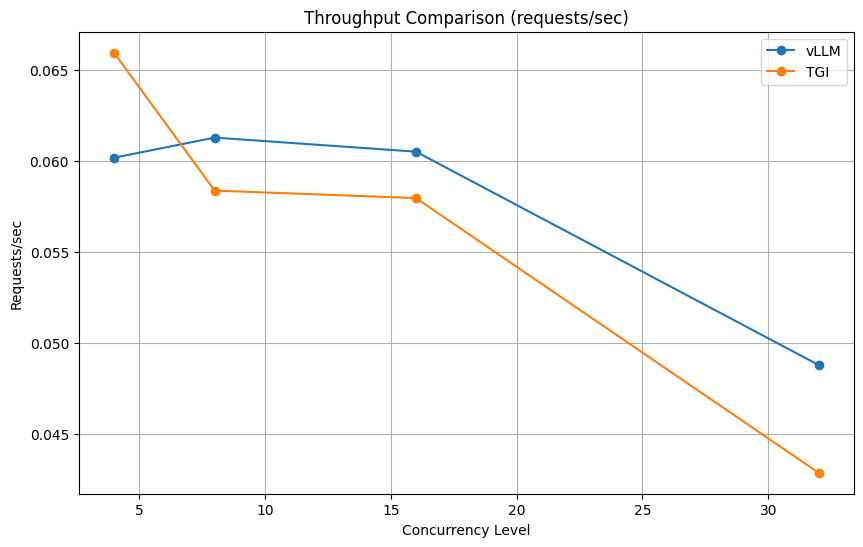

/opt/app-root/lib64/python3.11/site-packages/matplotlib/colors.py:247: RuntimeWarning: coroutine 'run_benchmark' was never awaited
  for k, v in kwargs.items():


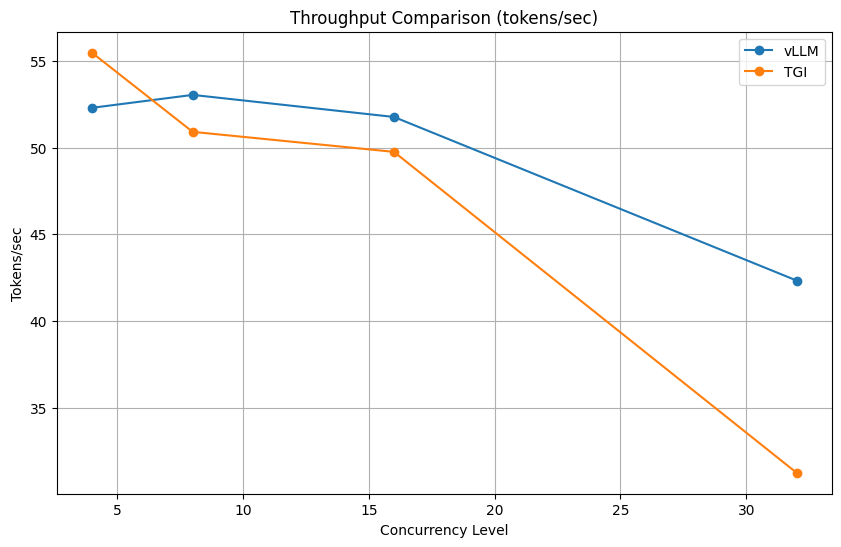

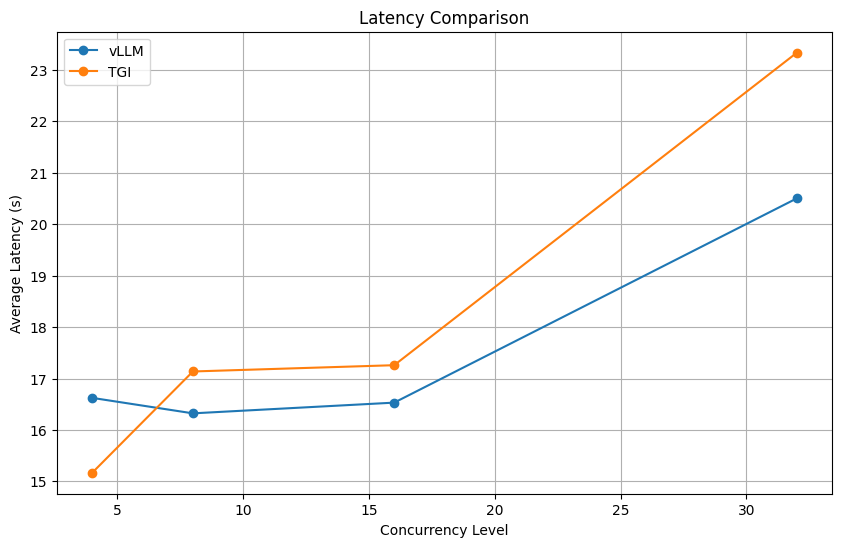

In [23]:
import nest_asyncio
nest_asyncio.apply()

import asyncio
import httpx
import random
import time
import numpy as np
import matplotlib.pyplot as plt

MAX_PROMPT_CHARS = 3000
NUM_PROMPTS = 30  # Reduce the load further if needed
CONCURRENCY_LEVELS = [4, 8, 16, 32]  # Skip 64 to avoid timeouts
HTTP_TIMEOUT = 120  # generous timeout to prevent premature 504 errors

async def send_request(client, url, body):
    start = time.time()
    try:
        resp = await client.post(url, headers=HEADERS, json=body, timeout=HTTP_TIMEOUT)
        duration = time.time() - start
        tokens = 0
        if resp.status_code == 200:
            data = resp.json()
            usage = data.get('usage', {})
            tokens = usage.get('prompt_tokens', 0) + usage.get('completion_tokens', 0)
        else:
            print(f"Request failed ({resp.status_code}): {resp.text}")
        return duration, tokens
    except httpx.RequestError as e:
        print(f"Request exception: {e}")
        return None, 0

async def run_benchmark(name, url, path, body_template, prompts, concurrency, results_dict):
    durations = []
    tokens_total = 0
    sem = asyncio.Semaphore(concurrency)

    async def bound_request(prompt):
        nonlocal tokens_total
        async with sem:
            body = body_template.copy()
            if "messages" in body:
                body["messages"] = [{"role": "user", "content": prompt}]
            elif "prompt" in body:
                body["prompt"] = prompt
            body["max_tokens"] = 256
            duration, tokens = await send_request(client, url + path, body)
            if duration is not None:
                durations.append(duration)
                tokens_total += tokens

    async with httpx.AsyncClient(timeout=HTTP_TIMEOUT, verify=False) as client:
        tasks = [bound_request(p) for p in prompts]
        await asyncio.gather(*tasks)

    if durations:  # Check if there were successful requests
        results_dict[concurrency] = {
            'avg_latency': np.mean(durations),
            'req_per_sec': len(durations) / sum(durations),
            'tokens_per_sec': tokens_total / sum(durations),
            'durations': durations,
        }
    else:
        print(f"No successful responses for {name} at concurrency {concurrency}")

# Generate prompts
test_prompts = [p[:MAX_PROMPT_CHARS] for p in random.sample(prompts, NUM_PROMPTS)]

all_results = {'vLLM': {}, 'TGI': {}}

for concurrency in CONCURRENCY_LEVELS:
    print(f"\n🚀 Benchmarking at concurrency={concurrency}")

    tasks = [
        run_benchmark('vLLM', VLLM, VLLM_PATH, VLLM_BODY, test_prompts, concurrency, all_results['vLLM']),
        run_benchmark('TGI', TGI, TGI_PATH, TGI_BODY, test_prompts, concurrency, all_results['TGI'])
    ]

    await asyncio.gather(*tasks)

print("\n✅ Benchmarking complete.\n")

# Visualization
def safe_get(metric_dict, concurrencies, metric):
    return [metric_dict.get(c, {}).get(metric, np.nan) for c in concurrencies]

valid_concurrencies = [c for c in CONCURRENCY_LEVELS if c in all_results['vLLM'] and c in all_results['TGI']]

plt.figure(figsize=(10, 6))
plt.plot(valid_concurrencies, safe_get(all_results['vLLM'], valid_concurrencies, 'req_per_sec'), marker='o', label='vLLM')
plt.plot(valid_concurrencies, safe_get(all_results['TGI'], valid_concurrencies, 'req_per_sec'), marker='o', label='TGI')
plt.xlabel('Concurrency Level')
plt.ylabel('Requests/sec')
plt.title('Throughput Comparison (requests/sec)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(valid_concurrencies, safe_get(all_results['vLLM'], valid_concurrencies, 'tokens_per_sec'), marker='o', label='vLLM')
plt.plot(valid_concurrencies, safe_get(all_results['TGI'], valid_concurrencies, 'tokens_per_sec'), marker='o', label='TGI')
plt.xlabel('Concurrency Level')
plt.ylabel('Tokens/sec')
plt.title('Throughput Comparison (tokens/sec)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(valid_concurrencies, safe_get(all_results['vLLM'], valid_concurrencies, 'avg_latency'), marker='o', label='vLLM')
plt.plot(valid_concurrencies, safe_get(all_results['TGI'], valid_concurrencies, 'avg_latency'), marker='o', label='TGI')
plt.xlabel('Concurrency Level')
plt.ylabel('Average Latency (s)')
plt.title('Latency Comparison')
plt.legend()
plt.grid(True)
plt.show()
